In [9]:
from transformer.models import TrfmSeq2seqProp2
from transformer.dataset import Seq2seqDatasetProp
from transformer.build_vocab import WordVocab
import pandas as pd

In [15]:
class args:
    batch_size = 32
    n_worker = 56
    hidden = 256
    n_layer = 4
    n_head = 4
    lr = 1e-4

In [16]:
class TRFM(TrfmSeq2seqProp2):
    def __init__(self, *args):
        self.vocab = WordVocab.load_vocab("data/vocab.pkl")
        self.seq_len = 220
        super().__init__(*args)
    
    def _encode(self, smiles):
        content = [[self.vocab.stoi.get(token, self.vocab.unk_index) for token in sm] for sm in smiles]
        X = [[self.vocab.sos_index] + c + [self.vocab.eos_index] for c in content]
        padding = [[self.vocab.pad_index]*(self.seq_len - len(x)) for x in X]
        for x,p in zip(X, padding): x.extend(p)
        X = torch.tensor(X, device='cuda') if next(self.parameters()).is_cuda else torch.tensor(X)
        X = X.view(-1, 220)
        embedded = self.embed(X)
        output = self.pe(embedded)
        for mod in self.trfm.encoder.layers:
            output = mod(output, None)
        if self.trfm.encoder.norm:
            output = self.trfm.encoder.norm(output)
        encoded = output.mean(1)
        return encoded
    
    def encode(self, smiles, limit=32):
        if isinstance(smiles, str):
            smiles = [smiles]
        
        if len(smiles) < limit:
            return self._encode(smiles)
        
        output = None
        for i in range(0, len(smiles), limit):
            _output = self._encode(smiles[i:i+limit]).cpu()
            output =  _output if output is None else torch.cat((output, _output), 0)
            
        return output

In [17]:
import torch
torch.manual_seed(0)

In [19]:
vocab = WordVocab.load_vocab("data/vocab.pkl")
dataset = Seq2seqDatasetProp(pd.read_csv("data/chembl_24_chemreps.csv"), vocab)
test_size = 10000
train, test = torch.utils.data.random_split(dataset, [len(dataset)-test_size, test_size])
train_loader = torch.utils.data.DataLoader(train, batch_size=args.batch_size, shuffle=True, num_workers=args.n_worker)
test_loader = torch.utils.data.DataLoader(test, batch_size=args.batch_size, shuffle=False, num_workers=args.n_worker)
print('Train size:', len(train))
print('Test size:', len(test))
del dataset, train, test

# model = TrfmSeq2seqProp2(len(vocab), args.hidden, len(vocab), args.n_layer).cuda()
model = TRFM(len(vocab), args.hidden, len(vocab), args.n_layer)
model.load_state_dict(torch.load("exps/exp1/ST_49_1767-0.320578.pkl"))
# model = nn.DataParallel(model)
# optimizer = optim.Adam(model.parameters(), lr=args.lr)
print('Total parameters:', sum(p.numel() for p in model.parameters()))

Train size: 1810001
Test size: 10000
Total parameters: 4803694


In [20]:
from torchsummaryX import summary

In [21]:
# model.train()
# summary(model, torch.zeros([8, 220]).long().cuda())

In [22]:
# model.load_state_dict(torch.load("total_loss_mean_encoded/custom_194_232-0.197752.pkl"))
# model.load_state_dict(torch.load("exp2/custom_195_232-0.108540.pkl"))
model.cuda()
model.eval()

TRFM(
  (embed): Embedding(75, 256)
  (pe): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (trfm): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=256, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
  

#### Encode

In [25]:
df = pd.read_csv ("../transformer/data/250k_rndm_zinc_drugs_clean_3_modified.csv")
df.head()

smiles     logP       qed       SAS
0            CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1  5.05060  0.702012  2.084095
1       C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1  3.11370  0.928975  3.432004
2  N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...  4.96778  0.599682  2.470633
3  CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...  4.00022  0.690944  2.822753
4  N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...  3.60956  0.789027  4.035182

In [26]:
smiles = df.smiles.to_list()
encoded = []
for i in range(0, len(smiles), 64):
    _encoded = model.encode(smiles[i:i+64], limit=64).tolist()
    encoded.extend(_encoded)

In [27]:
len(encodeded)

248592

In [28]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


Bad key "text.kerning_factor" on line 4 in
/home/mhassan/miniconda3/envs/smiles_transformer/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution
/home/mhassan/miniconda3/envs/smiles_transformer/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/mhassan/miniconda3/envs/smiles_transformer/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/mhassan/miniconda3/envs/smiles_transformer/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate bi

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(encoded)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

/home/mhassan/miniconda3/envs/smiles_transformer/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/mhassan/miniconda3/envs/smiles_transformer/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [14]:
# finalDf = pd.concat([principalDf, df[['logP']]], axis = 1)

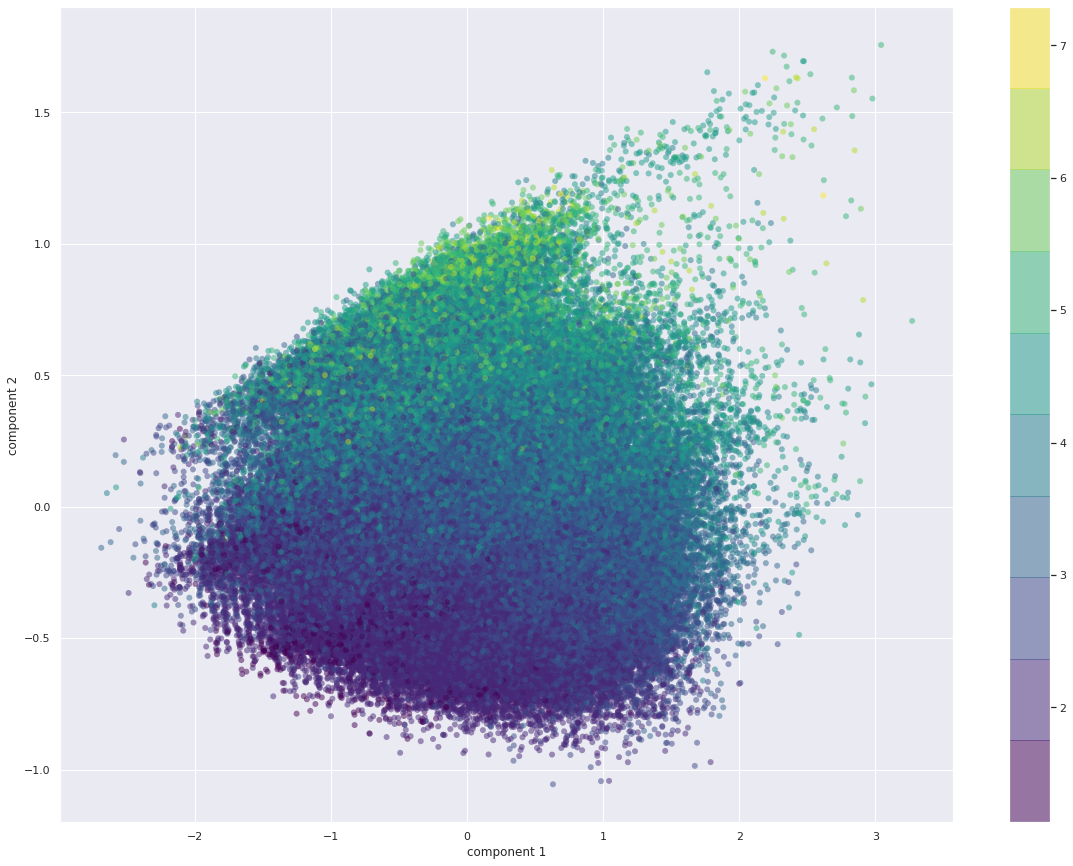

In [30]:
plt.figure(figsize=(20, 15))
plt.scatter(principalComponents[:, 0], principalComponents[:, 1],
            c=df.SAS, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('viridis', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

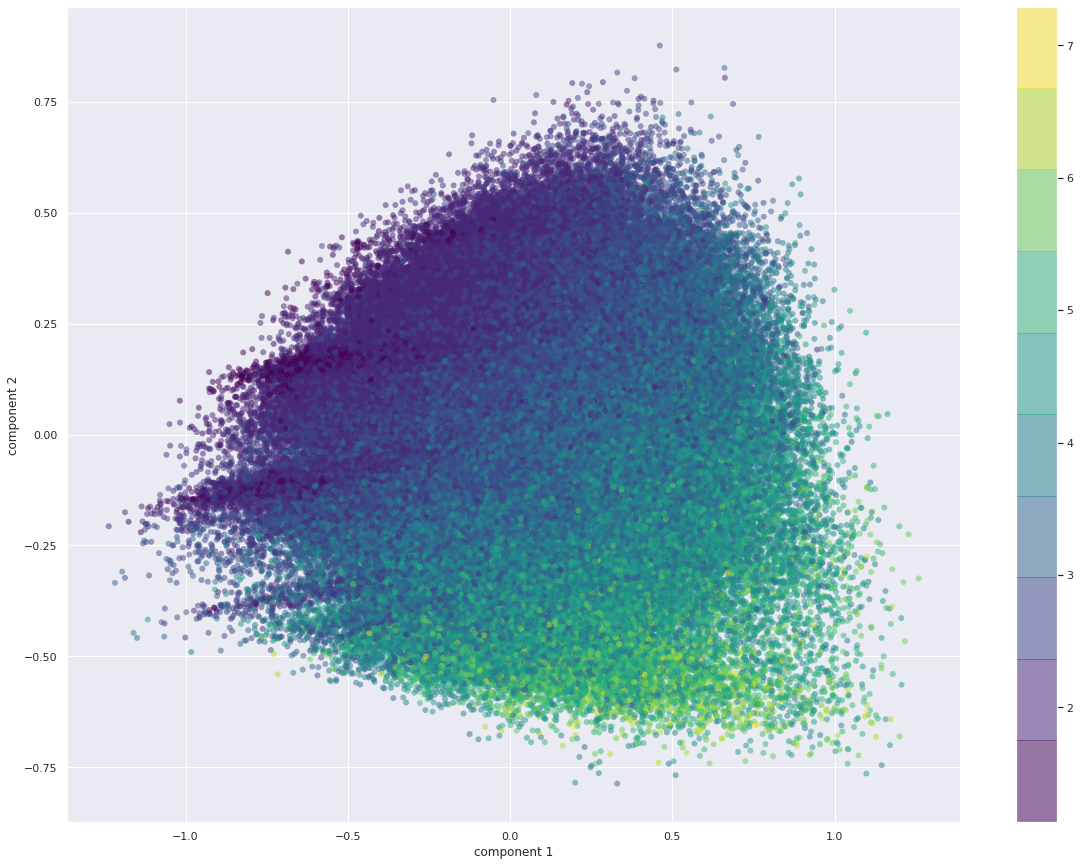

In [15]:
plt.figure(figsize=(20, 15))
plt.scatter(principalComponents[:, 0], principalComponents[:, 1],
            c=df.SAS, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('viridis', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

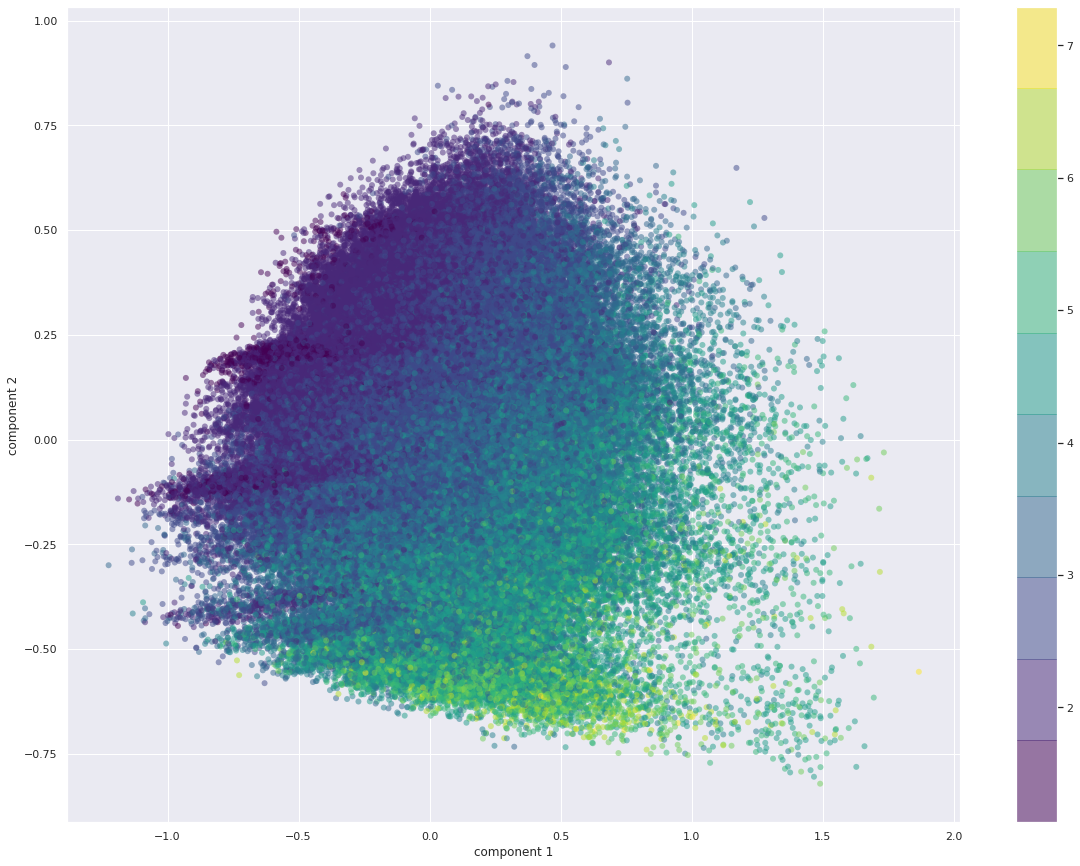

In [49]:
plt.figure(figsize=(20, 15))
plt.scatter(principalComponents[:, 0], principalComponents[:, 1],
            c=df.SAS, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('viridis', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

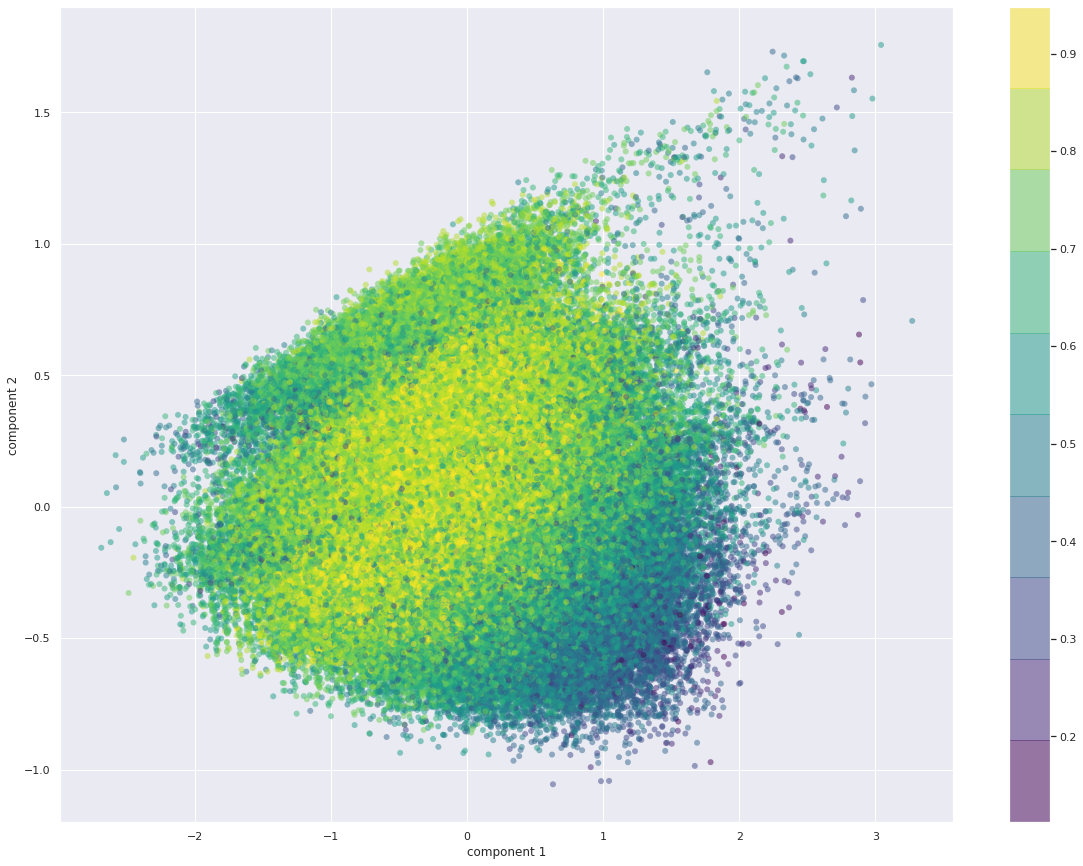

In [31]:
plt.figure(figsize=(20, 15))
plt.scatter(principalComponents[:, 0], principalComponents[:, 1],
            c=df.qed, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('viridis', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

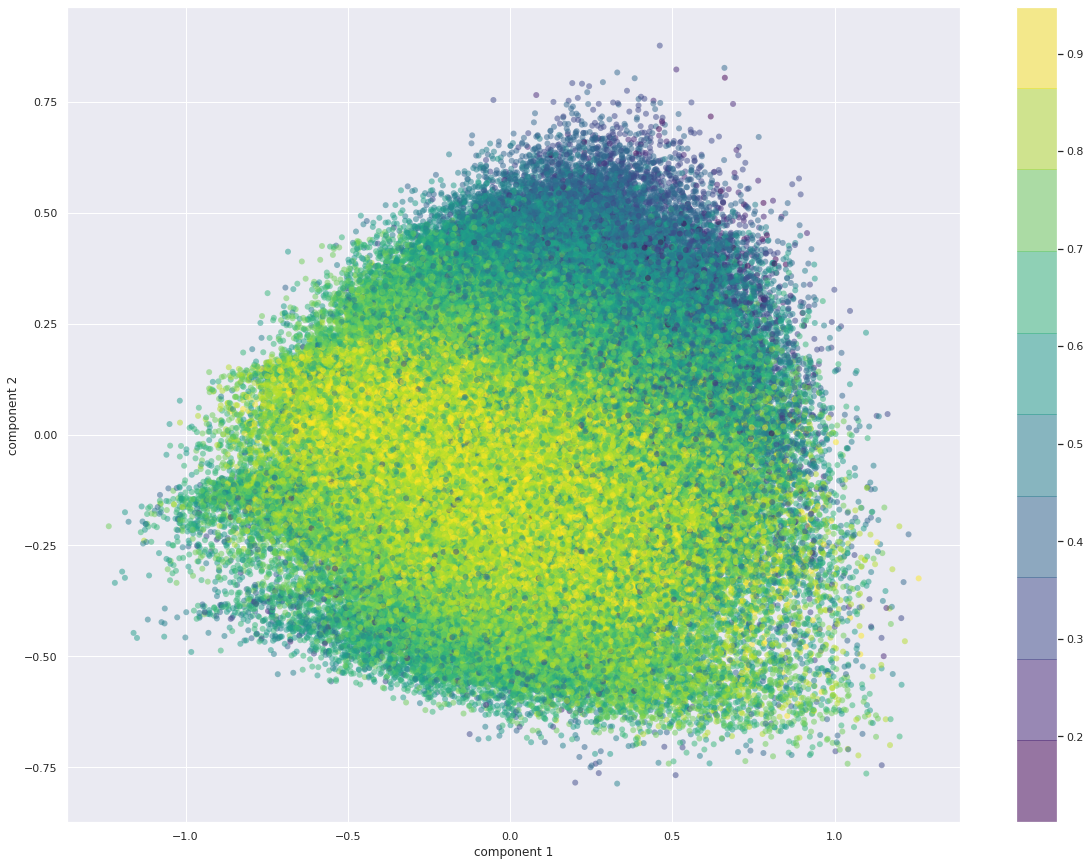

In [16]:
plt.figure(figsize=(20, 15))
plt.scatter(principalComponents[:, 0], principalComponents[:, 1],
            c=df.qed, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('viridis', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

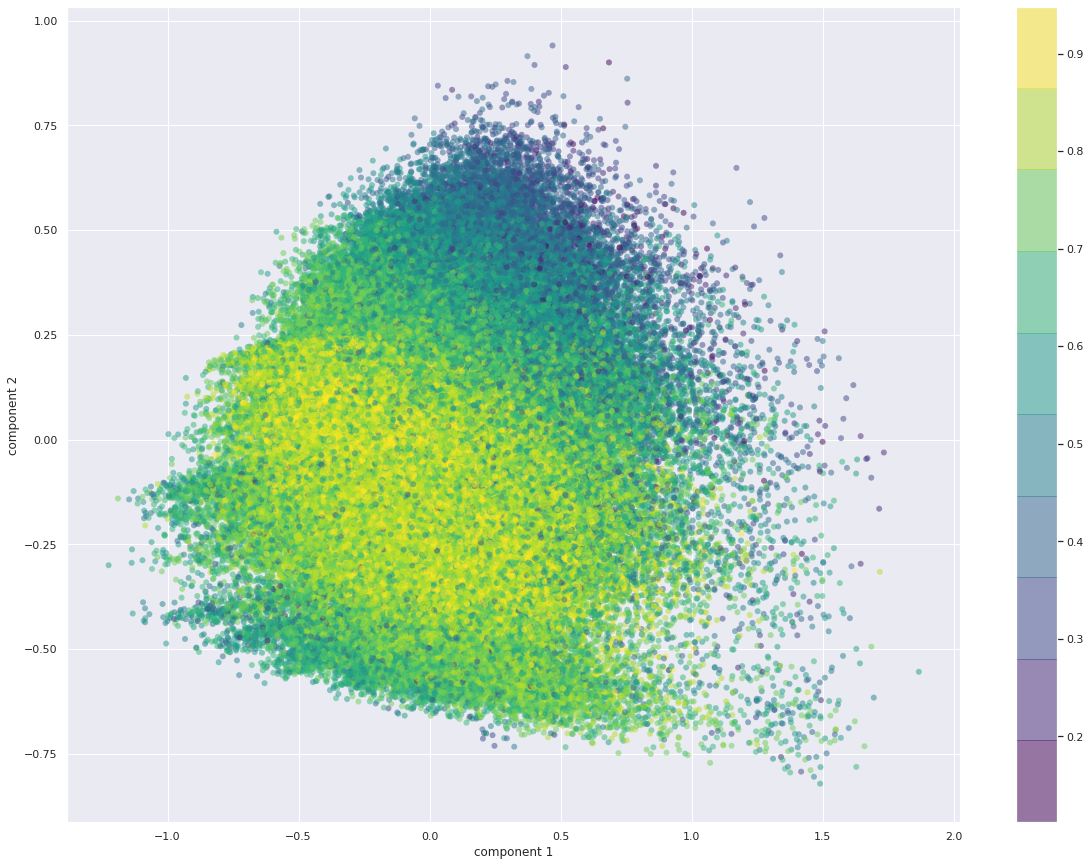

In [41]:
plt.figure(figsize=(20, 15))
plt.scatter(principalComponents[:, 0], principalComponents[:, 1],
            c=df.qed, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('viridis', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

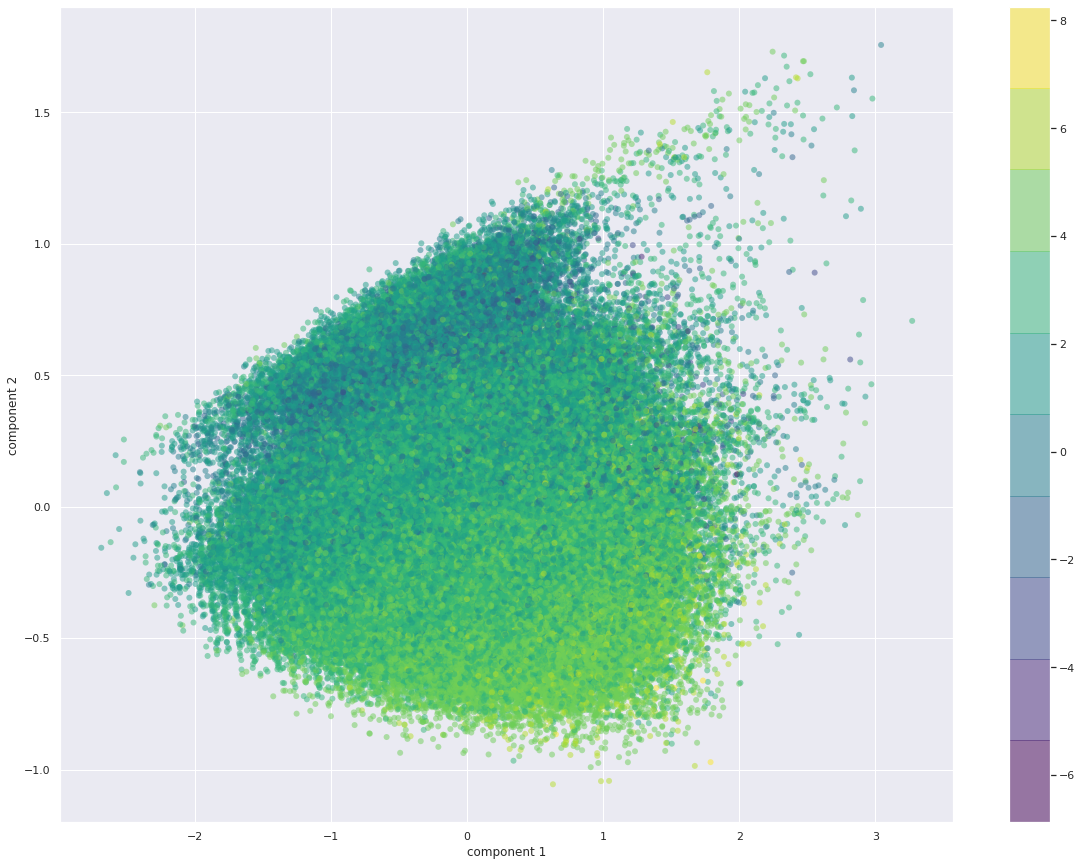

In [32]:
plt.figure(figsize=(20, 15))
plt.scatter(principalComponents[:, 0], principalComponents[:, 1],
            c=df.logP, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('viridis', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

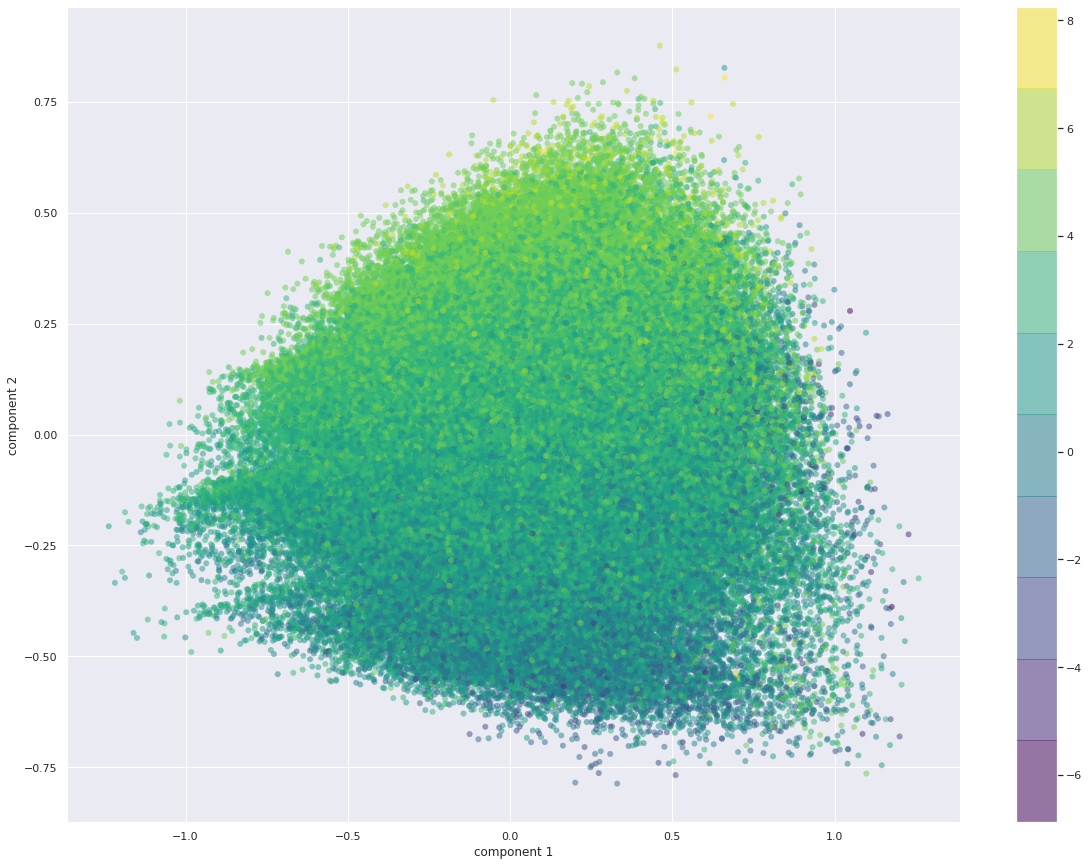

In [17]:
plt.figure(figsize=(20, 15))
plt.scatter(principalComponents[:, 0], principalComponents[:, 1],
            c=df.logP, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('viridis', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

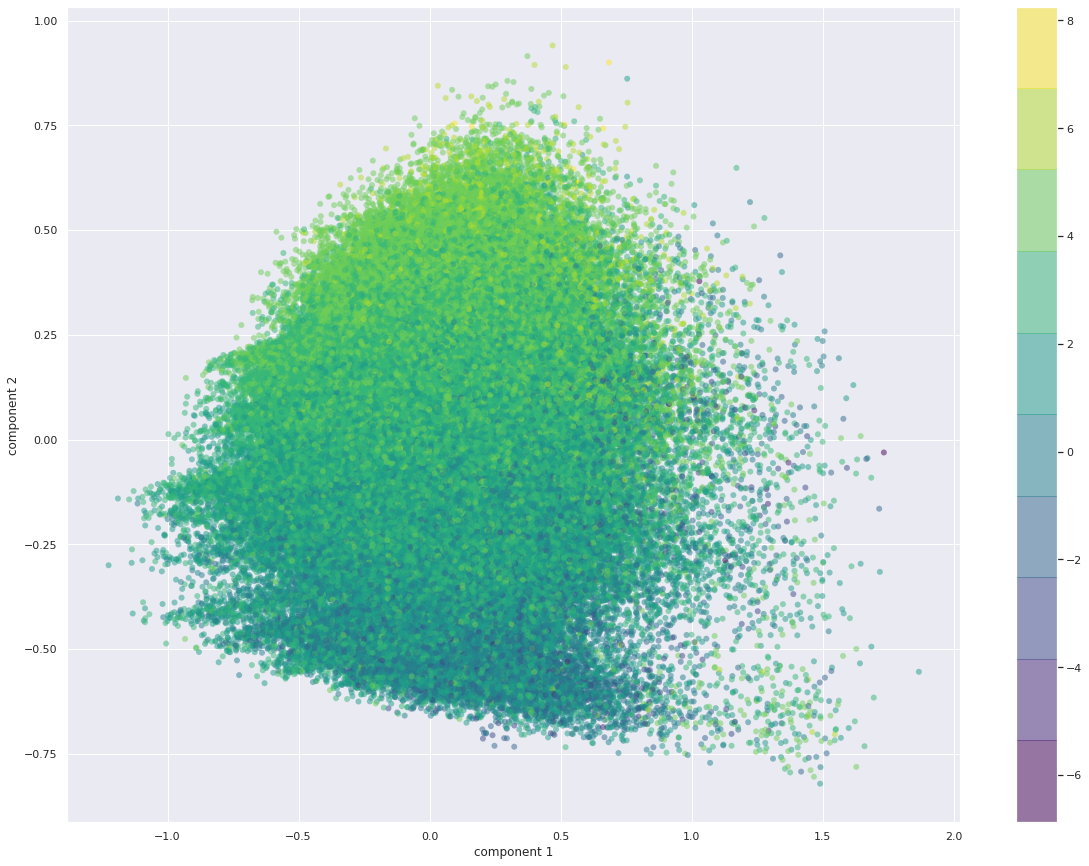

In [40]:
plt.figure(figsize=(20, 15))
plt.scatter(principalComponents[:, 0], principalComponents[:, 1],
            c=df.logP, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('viridis', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [37]:
# fig = plt.figure(figsize = (8,8))
# ax = fig.add_subplot(1,1,1) 
# ax.set_xlabel('Principal Component 1', fontsize = 15)
# ax.set_ylabel('Principal Component 2', fontsize = 15)
# ax.set_title('2 component PCA', fontsize = 20)

# targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
# colors = ['r', 'g', 'b']
# for target, color in zip(targets,colors):
#     indicesToKeep = finalDf['target'] == target
#     ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
#                , finalDf.loc[indicesToKeep, 'principal component 2']
#                , c = color
#                , s = 50)
# ax.legend(targets)
# ax.grid()

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

In [19]:
ytrue = []
pred = []
for i, (x, y) in enumerate(test_loader):
    x_, y_ = model(x.cuda())
    ypred = y_.cpu().detach().numpy()
    ytrue.append(y.numpy().tolist())
    pred.append(ypred.tolist())

In [20]:
ytrue = np.array(ytrue).reshape(-1, 3)

In [21]:
pred = np.array(pred).reshape(-1, 3)
pred.shape

(10000, 3)

In [22]:
ytrue[:10]

array([[2.48912001, 0.87155604, 2.90436029],
       [4.3728199 , 0.52320921, 3.00006413],
       [1.70389998, 0.55454904, 2.7959106 ],
       [2.5934999 , 0.62477797, 1.80629849],
       [1.23730004, 0.84863997, 3.27287507],
       [2.84139991, 0.74283296, 2.98132992],
       [2.33069992, 0.53598821, 2.28890133],
       [1.64979994, 0.83673912, 2.23371029],
       [4.31409979, 0.40532842, 3.31469488],
       [4.34259987, 0.45413354, 1.91209841]])

In [54]:
ytrue[:10]

array([[3.17641997, 0.72020775, 2.22161222],
       [1.02460003, 0.74862611, 5.57815647],
       [1.83420002, 0.88744205, 2.04742122],
       [2.86739993, 0.70333987, 4.16476583],
       [3.4612    , 0.75824827, 3.09524703],
       [2.08141994, 0.80861384, 2.39083862],
       [1.21159995, 0.86216146, 3.27599049],
       [2.37940001, 0.87313586, 2.73319983],
       [2.57347989, 0.38879719, 3.0209446 ],
       [4.0012002 , 0.70920771, 2.03346086]])

In [23]:
pred[:10]

array([[2.32011867, 0.76996607, 3.12949014],
       [3.53152061, 0.57421917, 3.1606102 ],
       [1.95768654, 0.59469008, 2.82457376],
       [2.0039134 , 0.74623811, 2.20340991],
       [2.11450219, 0.71948564, 2.96898437],
       [2.39666796, 0.69437623, 2.98862314],
       [2.72109985, 0.66400999, 2.47861338],
       [2.20736456, 0.80831945, 2.55079985],
       [3.48163867, 0.37946719, 3.56809139],
       [3.47283459, 0.53179878, 2.07109761]])

In [55]:
pred[:10]

array([[ 1.07845604,  0.77932614,  3.39214969],
       [-0.4358775 ,  0.69361573,  5.8562007 ],
       [ 0.73840052,  0.7166205 ,  3.0867188 ],
       [ 0.47007126,  0.66374236,  3.83219194],
       [ 1.872509  ,  0.83374637,  3.8364141 ],
       [ 1.2644496 ,  0.69480407,  3.19683194],
       [-0.60438919,  0.78855348,  4.2927227 ],
       [ 2.17522144,  0.83376616,  3.06393218],
       [ 1.27193344,  0.56774169,  3.68747473],
       [ 2.4443872 ,  0.65512019,  3.12913013]])

In [24]:
[mean_absolute_error(ytrue[:, i], pred[:, i]) for i in range(3)]

[0.5443625929228146, 0.07943312950283289, 0.24601866942644118]

In [56]:
[mean_absolute_error(ytrue[:, i], pred[:, i]) for i in range(3)]

[0.5504938158177188, 0.06508933216333389, 0.27450653302669525]

Best: 
    - logP: GC: 0.05 VAE: 0.15
    - qed: encoder: 0.037

logp, qed, SAS

TODO:
    * Use objective: 5 × QED − SAS to train, use this as a target for pca plots (as in the chem vae paper)
    * Increase prediction performance
    * Generate new compounds and check validity